<i>This notebook is made by Haozhe TANG on 21, July for the final project of Computer Vision.</i>

# Library importing, Data importing and splitting

In [1]:
! pip install chess

In [2]:
#Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import seaborn
import os
import random
import glob
import re
import chess
import chess.svg
from IPython.display import SVG, display
from google.colab import files

#Computer Vision
import cv2

#Sklearn
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix,
                             f1_score,
                             accuracy_score,
                             precision_score,
                             recall_score)

#tensorflow
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
import keras

In [3]:
# Kaggle API settings
import json
token = {"username":"skyemalfoy","key":"ad5f5925262d70cacf98edfa498d4778"}
with open('./kaggle.json', 'w') as file:
  json.dump(token, file)

!mkdir -p ~/.kaggle
!cp ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v /content
!kaggle datasets download -d koryakinp/chess-positions
!unzip /content/datasets/koryakinp/chess-positions/*.zip

- path is now set to: /content
chess-positions.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/datasets/koryakinp/chess-positions/chess-positions.zip
replace dataset/test/1B1B2K1-1B6-5N2-6k1-8-8-8-4nq2.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
#Import dataset
#Because the limitation of the device, we only use 20,000 images in this project (the testset)
#Define the filepath. We only source the first 20k images (total: 80000)
filepath = glob.glob("./dataset/train/*.jpeg")[:20000]


#Shuffle the dataset, to make the dataset be random.
random.shuffle(filepath)

#Define the types of pieces:
piece_symbols = 'prbnkqPRBNKQ'


In this project, we plan to split the dataset into:
 - 70% for training set;
 - 10% for validation set;
 - 20% for testing set.

In [5]:
#Range of train, validation and test samples
#Define the size of those three datasets according to the ratio.
train_size = int(len(filepath) * 0.7)
val_size = int(len(filepath) * 0.1)
test_size = int(len(filepath) * 0.2)

train = filepath[:train_size]
val = filepath[train_size:train_size+val_size]
test = filepath[train_size+val_size:]


In [6]:
# Get the labels (FEN) for the datasets.
def get_image_FEN_label(image_path):
  fen_label = image_path.replace('.jpeg', '').split('/')[-1]
  return fen_label

# 1. Images preview

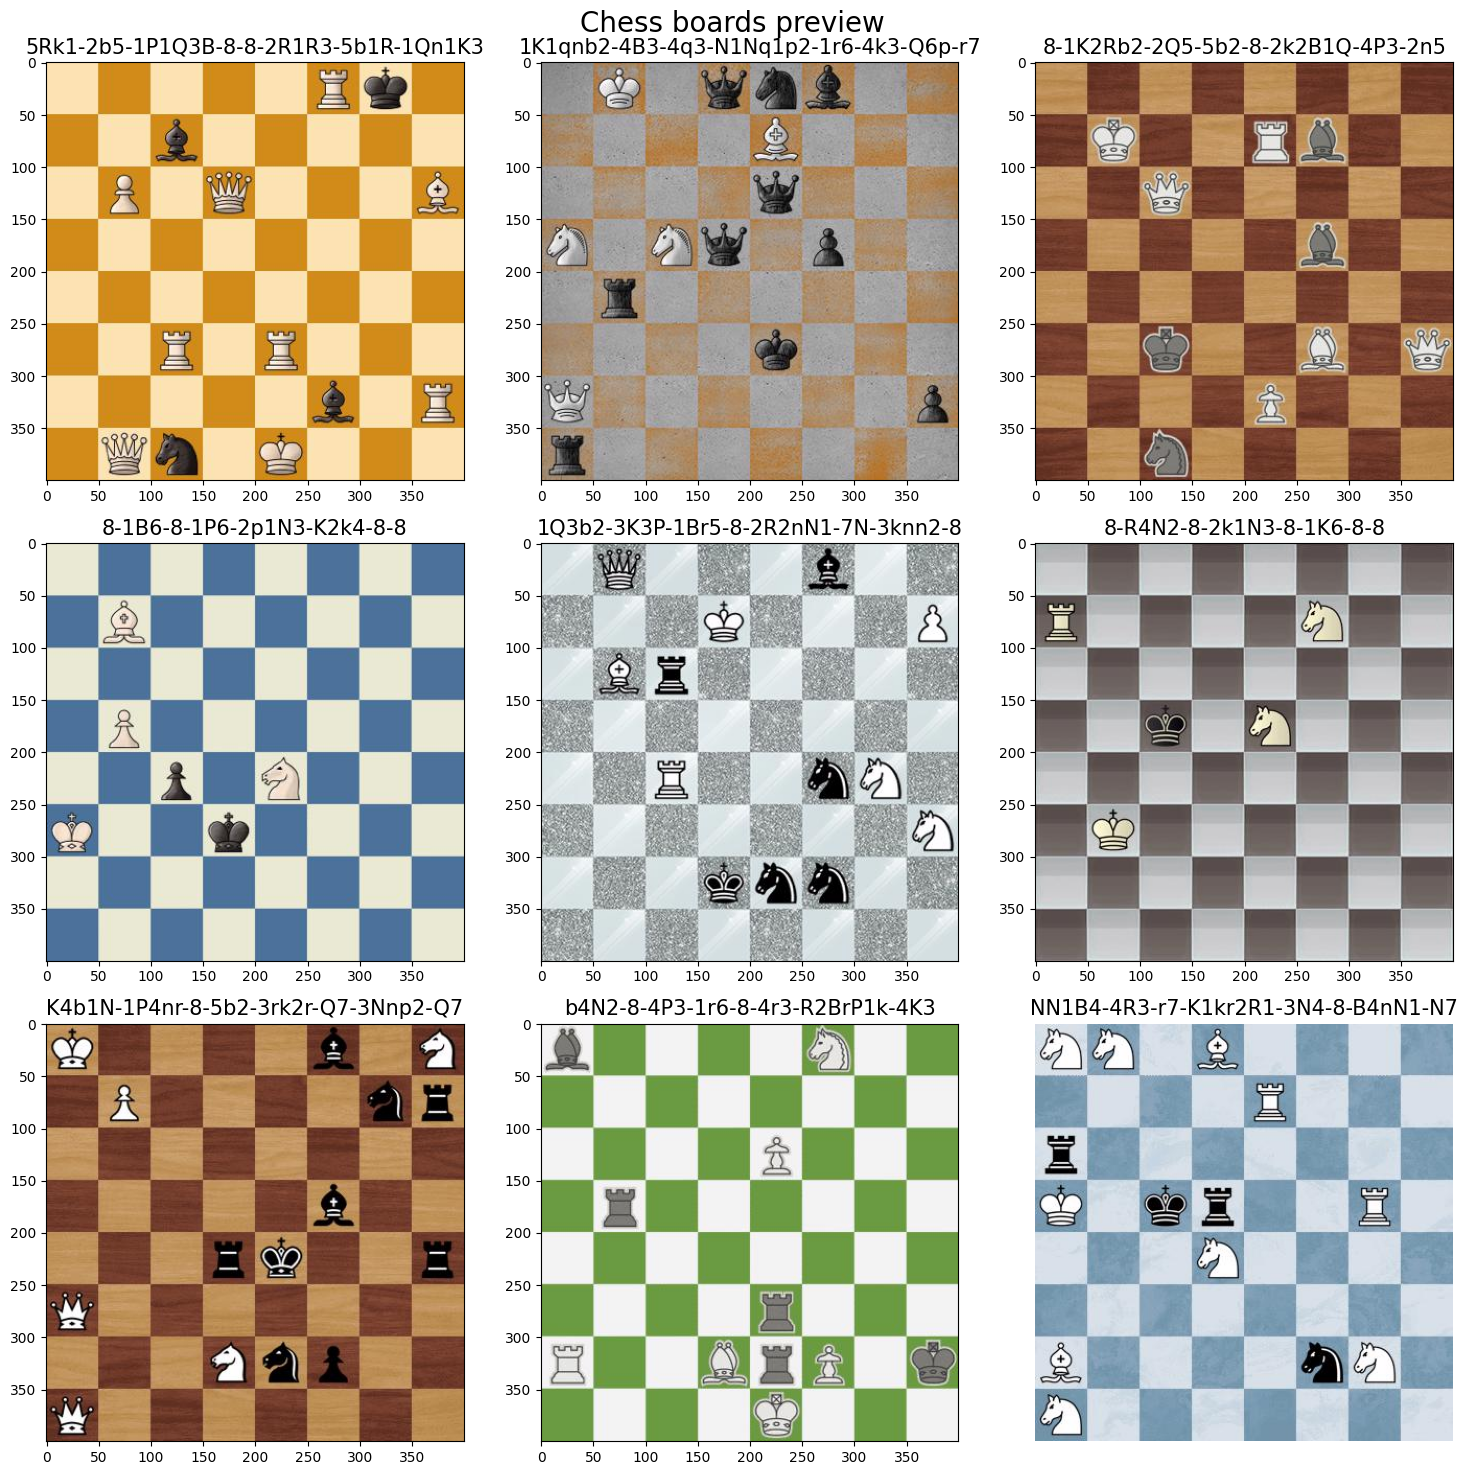

In [7]:
# Display some examples randomly from the dataset.
fig, axes = plt.subplots(3, 3, figsize=(15,15))

for ax, _ in zip(axes.flat, range(9)):
  id_images = random.randint(0, 20000)
  img_path = filepath[id_images]
  img_name = get_image_FEN_label(img_path)
  img = cv2.imread(img_path)
  ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  ax.set_title(img_name, fontsize=15)
  plt.suptitle('Chess boards preview', fontsize=20)
  plt.axis('off')
plt.tight_layout()
plt.show()


# 2. Data Preprocessing

## 2.1 Image processing

In [8]:
def preprocess_images(img_paths, width, height):
  resized_imgs = []

  for img_path in img_paths:

    # Read the image in grayscale (convert 3D color image to 2D grayscale image)
    img = cv2.imread(img_path, cv2.COLOR_BGR2GRAY)

    # Resize the grayscale image to the desired width and height.
    gray_image = cv2.resize(img, (width, height))

    # Normalize the pixel values of the image. This will transform the pixel values to be between 0 and 1.
    # The method is to subtract the minimum pixel value and divide by the range of pixel values (max - min).
    gray_image = (gray_image - np.min(gray_image)) / (np.max(gray_image) - np.min(gray_image))

    resized_imgs.append(gray_image)

  return resized_imgs

## 2.2 Feature Engineering

### 2.2.1 Chess board splitting

In [9]:
# Function to split the chess board into pieces.
def image_to_squares(img,heights,widths):
  squares = []
  for i in range(0,8):
    for j in range(0,8):
      squares.append(img[i*heights//8:i*heights//8+heights//8,j*widths//8:j*widths//8+widths//8])
  return np.array(squares)

In [10]:
def img_processing(img_path):
  height =240
  width =240

  # change to Grey scal
  img = cv2.imread(img_path, cv2.COLOR_BGR2GRAY)

  # resize the image to the desired size
  gray_image = cv2.resize(img, (width, height))

  # Normalize the image
  gray_image =(gray_image - np.min(gray_image)) / (np.max(gray_image) - np.min(gray_image))

  squares = image_to_squares(gray_image,height,width)
  return squares

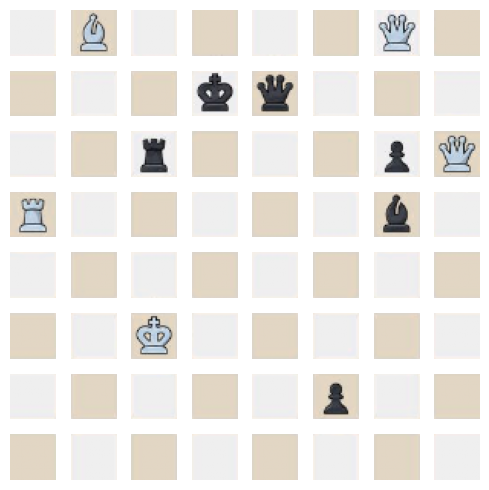

In [11]:
#Example visualisation
squares = img_processing(filepath[0])
fig = plt.figure(figsize=(5, 5))
columns = 8
rows = 8
for i, img in zip(range(1, columns*rows +1), squares):
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.tight_layout()
plt.show()

In [12]:
squares.shape

(64, 30, 30, 3)

## 2.2.1 FEN label - one-hot encoding converting.

In [13]:
#Functions to transform label between FEN label and one-hot encoding.
def onehot_from_fen(fen):
  eye = np.eye(13)
  # Initialize an empty array
  output = np.empty((0, 13))
  fen = re.sub('[-]', '', fen)

  for char in fen:
    # If the character is a number (indicating an empty square count),
    # append that number of empty square encodings to the output array.
    if(char in '12345678'):
      output = np.append(output, np.tile(eye[12], (int(char), 1)), axis=0)
    # If the character is a piece, find its index in the list of piece symbols,
    # and append the corresponding one-hot encoding to the output array.
    else:
      idx = piece_symbols.index(char)
      output = np.append(output, eye[idx].reshape((1, 13)), axis=0)
  return output

# convert one-hot encoding to FEN notation
def fen_from_onehot(one_hot):
  output = ''
  for j in range(8):
    for i in range(8):
      if(one_hot[j][i] == 12):
        output += ' '
      else:
        output += piece_symbols[one_hot[j][i]]
    if(j != 7):
      output += '-'

  for i in range(8, 0, -1):
    output = output.replace(' ' * i, str(i))

  return output

## 2.2 Processing images

In [14]:
# Create a function divide the data into training and testing sets.
#Generator for training dataset.
def train_gen(features):
  for i, img in enumerate(features):
    y = onehot_from_fen(get_image_FEN_label(img))
    x = img_processing(img)
    yield x, y

#Generator for validation and testing dataset.
def pred_gen(features):
  for i, img in enumerate(features):
    y = onehot_from_fen(get_image_FEN_label(img))
    x = img_processing(img)
    yield x, y

# 3. CNN model

## 3.1 Build model

In this case, we plan to build the model as follows:
 - **A sequential model** to build and take the construction;
 - **Convolution2D layer1** for taking the input images with the size of (30, 30, 3) (which are the squares)
 - **Maxpooling 2D layer1** is to convert the input image to non-linear down-sampling.
 - **Convolution2D layer2** has only 32 filters and each of them are shaped 3 * 3
 - **Maxpooling2D layer2** is the second max pooling layer, which further reduces the dimensionality of the input
 - **Flatten** is to collapse the spatial dimensions of the input into one dimension
 - **Dropout** is to avoid overfitting
 - The last **Dense** is to control the output of this model. It has 13 output units because these are 13 possibilities for the output (12 kinds of pieces and 1 for empty space). Because it is a multi-class classification task, so we should use "softmax" activation function.

In [15]:
# Build a CNN model for training
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Convolution2D(64, (3, 3), activation='relu', input_shape=(30, 30, 3)))
model.add(keras.layers.convolutional.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Convolution2D(32, (3, 3), activation='relu'))
model.add(keras.layers.convolutional.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.core.Flatten())
model.add(keras.layers.core.Dropout(0.5))

# Becasue there are 12 possibilities of pieces and 1 for empty.
model.add(keras.layers.core.Dense(13, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



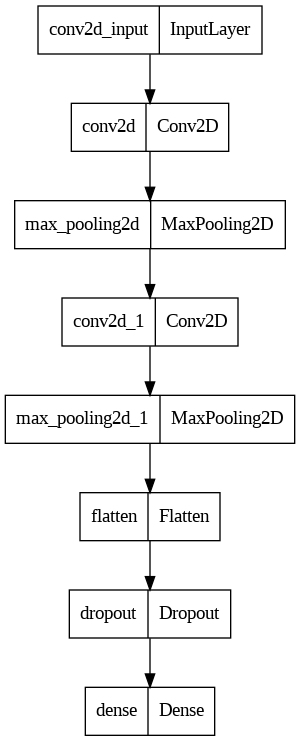

In [16]:
# Plot the model
plot_model(model)

## 3.2 Model training and fitting

In [17]:
EPOCHS = 10
# Start training and at the same time, using the validation datset for validating.
history = model.fit_generator(train_gen(train), steps_per_epoch=train_size//EPOCHS, epochs=EPOCHS,
                           validation_data=pred_gen(val), validation_steps=test_size//EPOCHS)

Epoch 1/10


<ipython-input-17-3a5949d71d6f>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen(train), steps_per_epoch=train_size//EPOCHS, epochs=EPOCHS,


1400/1400 [==============================] - 25s 15ms/step - loss: 0.1944 - accuracy: 0.9550 - val_loss: 0.0179 - val_accuracy: 0.9953
Epoch 2/10
1400/1400 [==============================] - 17s 12ms/step - loss: 0.0263 - accuracy: 0.9923 - val_loss: 0.0110 - val_accuracy: 0.9966
Epoch 3/10
1400/1400 [==============================] - 18s 13ms/step - loss: 0.0127 - accuracy: 0.9962 - val_loss: 0.0020 - val_accuracy: 0.9995
Epoch 4/10
1400/1400 [==============================] - 16s 11ms/step - loss: 0.0054 - accuracy: 0.9983 - val_loss: 0.0027 - val_accuracy: 0.9989
Epoch 5/10
1398/1400 [============================>.] - ETA: 0s - loss: 0.0071 - accuracy: 0.9980

1400/1400 [==============================] - 17s 12ms/step - loss: 0.0071 - accuracy: 0.9980 - val_loss: 0.0025 - val_accuracy: 0.9994
Epoch 6/10
1400/1400 [==============================] - 19s 13ms/step - loss: 0.0066 - accuracy: 0.9983
Epoch 7/10
1400/1400 [==============================] - 14s 10ms/step - loss: 0.0022 - accuracy: 0.9993
Epoch 8/10
1400/1400 [==============================] - 15s 11ms/step - loss: 0.0035 - accuracy: 0.9989
Epoch 9/10
1400/1400 [==============================] - 15s 11ms/step - loss: 0.0015 - accuracy: 0.9995
Epoch 10/10
1400/1400 [==============================] - 18s 13ms/step - loss: 0.0017 - accuracy: 0.9994


# 4. Model Evaluation

## 4.1 Learning Curve

In [18]:
#Build a function to plot learning curves
def plot_results(history):
    hist_df = pd.DataFrame(history.history)
    hist_df.columns=["loss", "accuracy", "val_loss", "val_accuracy"]
    hist_df.index = np.arange(1, len(hist_df)+1)

    fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
    axs[0].plot(hist_df.val_accuracy, lw=3, label='Validation Accuracy')
    axs[0].plot(hist_df.accuracy, lw=3, label='Training Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].grid()
    axs[0].legend(loc=0)
    axs[1].plot(hist_df.val_loss, lw=3, label='Validation Loss')
    axs[1].plot(hist_df.loss, lw=3, label='Training Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].grid()
    axs[1].legend(loc=0)

    plt.show()

In [22]:
# To keep the same length of train and validation history. So we append 0 to the validation accuracy and loss.
for i in range(len(history.history['accuracy']) - len(history.history['val_accuracy'])):
  history.history['val_accuracy'].insert(i,0)

  history.history['val_loss'].insert(i,0)


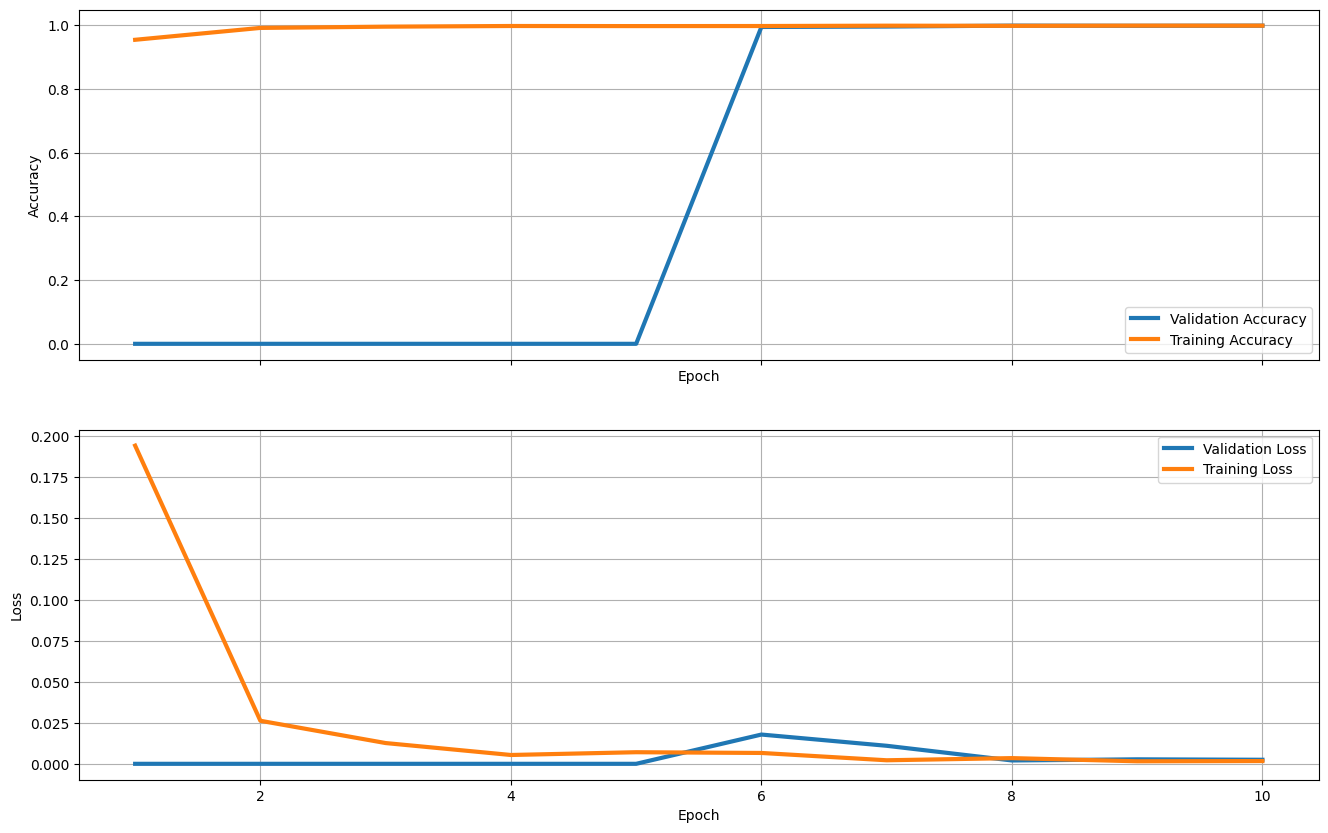

In [25]:
plot_results(history)

## 4.2 Prediction

In [26]:
# Predict the images with the trained model by using test dataset. And merge it to a complete board.
prediction = model.predict(pred_gen(test)).argmax(axis=1).reshape(-1, 8, 8)

4000/4000 [==============================] - 37s 9ms/step


In [33]:
#Transform the labels from one-hot encoded labels to FEN format labels.
pred_fens = np.array([fen_from_onehot(one_hot) for one_hot in prediction])
test_fens = np.array([get_image_FEN_label(fn) for fn in test])

final_accuracy = (pred_fens == test_fens).astype(float).mean()

print("Final Accuracy:", round(final_accuracy * 100, 2), '%')

Final Accuracy: 99.98 %


In [35]:
print("Precison:", round(precision_score(test_fens, pred_fens, average='weighted')*100, 2),'%')
print("Recall:", round(recall_score(test_fens, pred_fens, average='weighted')*100, 2),'%')
print("F1 Score:", round(f1_score(test_fens, pred_fens, average='weighted')*100, 2),'%')
print("Accuracy:", round(accuracy_score(test_fens, pred_fens)*100, 2),'%')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precison: 99.98 %
Recall: 99.98 %
F1 Score: 99.98 %
Accuracy: 99.98 %


2/2 [==============================] - 0s 9ms/step


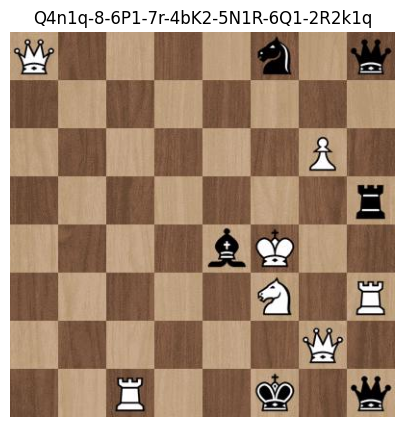

predicted FEN : Q4n1q-8-6P1-7r-4bK2-5N1R-6Q1-2R2k1q


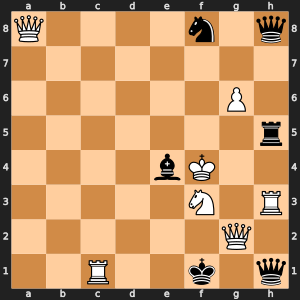

In [29]:
# Prediction visualisation
def display_with_predicted_fen(image):
    plt.figure(figsize=(5,5))
    pred = model.predict(img_processing(image)).argmax(axis=1).reshape(-1, 8, 8)
    fen = fen_from_onehot(pred[0])
    imgplot = plt.imshow(mpimg.imread(image))
    plt.axis('off')
    plt.title(fen)
    plt.show()
    return fen

predicted_fen = display_with_predicted_fen(test[230])
print("predicted FEN :",predicted_fen)
board = chess.Board(predicted_fen.replace('-', '/'))
display(SVG(chess.svg.board(board, size=300)))

### 4.3 Taking an image as input and predict

In [30]:
# Upload an image from the computer. (here I will choose one image from the "test" dataset on Kaggle that is not used in this exercise)
upload_img = files.upload()
img_name, = upload_img

Saving 1b1Q1B1R-8-r7-K2n4-q7-1P2k2N-8-BQ2N3.jpeg to 1b1Q1B1R-8-r7-K2n4-q7-1P2k2N-8-BQ2N3.jpeg


2/2 [==============================] - 0s 6ms/step


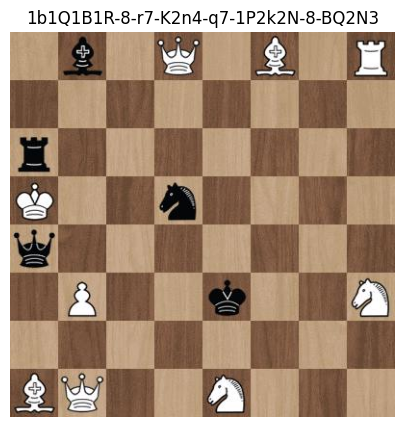

predicted FEN : 1b1Q1B1R-8-r7-K2n4-q7-1P2k2N-8-BQ2N3


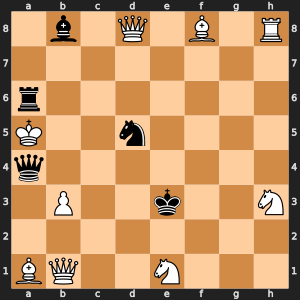

In [31]:
# Processing this image and put it into the model and predict its FEN label.
img_path = './' + str(img_name)
img_input = img_processing(img_path)

prediction = model.predict(img_input)
predicted_fen = display_with_predicted_fen(img_path)
print("predicted FEN :",predicted_fen)
board = chess.Board(predicted_fen.replace('-', '/'))
display(SVG(chess.svg.board(board, size=300)))

**We can see that even a random photo, this CNN model can recoginse and predict its label correctly. It has really good performance.**

# Copyright

## <h3 align="center"> © Haozhe TANG 07.2023. All rights reserved. <h3/>

# <i>References</i>

 - [Chess FEN Generator by PAVEL KORYAKIN](https://www.kaggle.com/code/koryakinp/chess-fen-generator)
 - [Chess Positions FEN Prediction (EDA + CNN Model) by IBRAHIM SOBOH ](https://www.kaggle.com/code/ibrahimsoboh/chess-positions-fen-prediction-eda-cnn-model)
 - [Chess FEN Generator Improved by PETER KERMAN](https://www.kaggle.com/code/meditech101/chess-fen-generator-improved)